# Call Center Balking and Abandonment Analysis

## Objective
This notebook analyzes call center data to understand balking (callers who hang up before entering the queue) and abandonment (callers who leave the queue while waiting) patterns. These behaviors are crucial for realistic discrete event simulation modeling.

## Why This Matters
- **Balking**: Occurs when callers see a long queue and choose not to wait
- **Abandonment**: Occurs when callers wait but leave before being served
- **Steady State**: Real call centers reach equilibrium where these behaviors balance incoming call volume
- **Simulation Accuracy**: Current DES model assumes infinite patience, leading to unrealistic queue growth

## Data Structure
The dataset contains half-hourly call center metrics including:
- Total calls attempted
- Connected calls (successful)
- Various abandonment categories
- Wait times and queue lengths
- Time-based patterns

## Analysis Goals
1. Calculate balking rates by time slot
2. Analyze abandonment patterns vs queue length
3. Model the relationship between wait time and abandonment
4. Identify steady-state conditions
5. Provide insights for improved DES modeling

In [1]:
# Standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Date/time handling
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All imports loaded successfully
Pandas version: 2.2.2
NumPy version: 1.26.4


In [2]:
# Load the call center data
data_path = "../data/data_sample.csv"
df = pd.read_csv(data_path)

print("📊 Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Time range: {df['Time'].min()} to {df['Time'].max()}")
print(f"Days of week: {sorted(df['Day'].unique())}")

print("\n" + "="*50)
print("FIRST 5 ROWS:")
print("="*50)
display(df.head())

print("\n" + "="*50)
print("DATA TYPES:")
print("="*50)
print(df.dtypes)

📊 Data loaded successfully!
Dataset shape: (134, 39)
Date range: 02/04/2024 to 10/04/2024
Time range: 08:00 to 18:00
Days of week: ['Fri', 'Mon', 'Thu', 'Tue', 'Wed']

FIRST 5 ROWS:


,Month,Day,Time,Date,Total Calls,Connected Calls,Calls Not Connected,Calls Not Connected (Length Limit Reached),Calls Not Connected (Contact Hung Up),Calls Not Connected (Caller Hangup Within 5 Seconds),...,Callback Avg Wait Time (s),Callback Avg Answer Time (s),Callback Avg Wrap Up Time (s),Callback Max Queue Length,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,Apr-24,Tue,08:00,02/04/2024,317,97,220,218,2,0,...,524,524,20,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Apr-24,Tue,08:30,02/04/2024,185,58,127,124,3,0,...,620,620,19,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr-24,Tue,09:00,02/04/2024,93,39,54,39,15,2,...,885,885,19,20,NaN,NaN,NaN,NaN,NaN,NaN
3,Apr-24,Tue,09:30,02/04/2024,70,33,37,21,16,5,...,974,951,18,20,NaN,NaN,NaN,NaN,NaN,NaN
4,Apr-24,Tue,10:00,02/04/2024,71,34,37,31,6,1,...,938,938,19,20,NaN,NaN,NaN,NaN,NaN,NaN



DATA TYPES:
Month                                                     object
Day                                                       object
Time                                                      object
Date                                                      object
Total Calls                                                int64
Connected Calls                                            int64
Calls Not Connected                                        int64
Calls Not Connected (Length Limit Reached)                 int64
Calls Not Connected (Contact Hung Up)                      int64
Calls Not Connected (Caller Hangup Within 5 Seconds)       int64
Calls Not Connected (Caller Hangup Within 10 Seconds)      int64
Calls Not Connected (Caller Hangup Within 20 Seconds)      int64
Availability (%)                                           int64
TOTAL CALLS INCLUDING HANGUPS (M)                          int64
Avg Call Length (s)                                        int64
Longest Wait

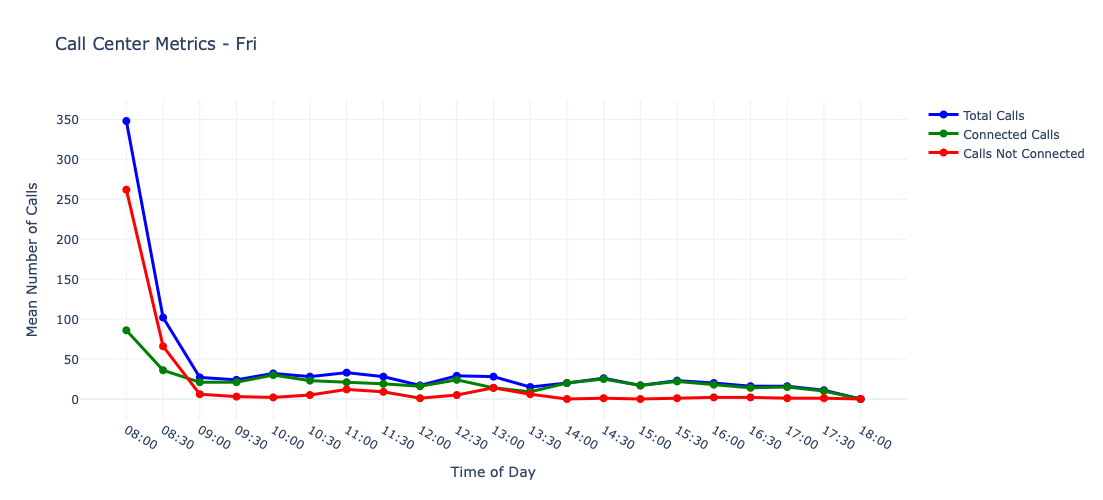


�� Summary for Fri:
Total Calls - Mean: 41.0, Max: 348.0
Connected Calls - Mean: 22.0, Max: 86.0
Calls Not Connected - Mean: 19.0, Max: 262.0
--------------------------------------------------


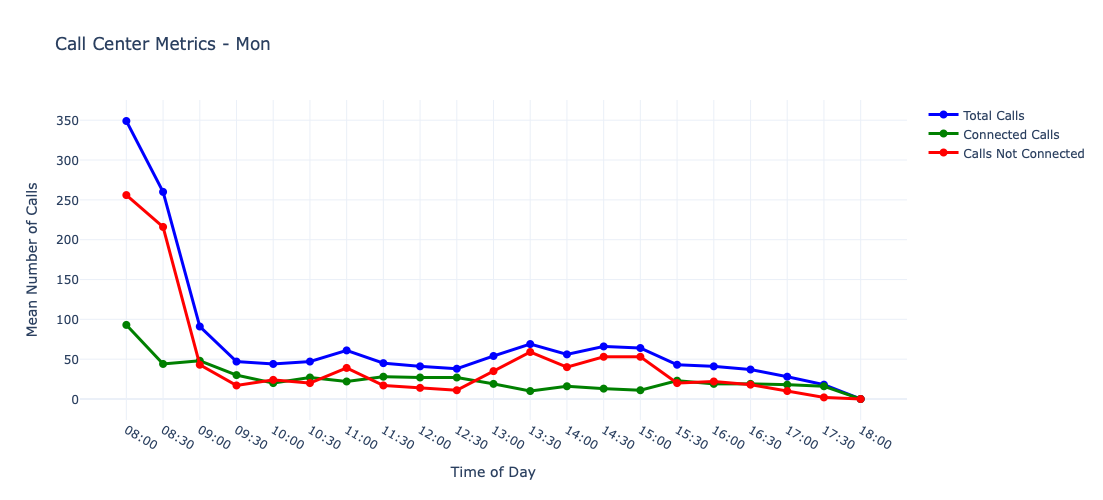


�� Summary for Mon:
Total Calls - Mean: 71.4, Max: 349.0
Connected Calls - Mean: 25.2, Max: 93.0
Calls Not Connected - Mean: 46.1, Max: 256.0
--------------------------------------------------


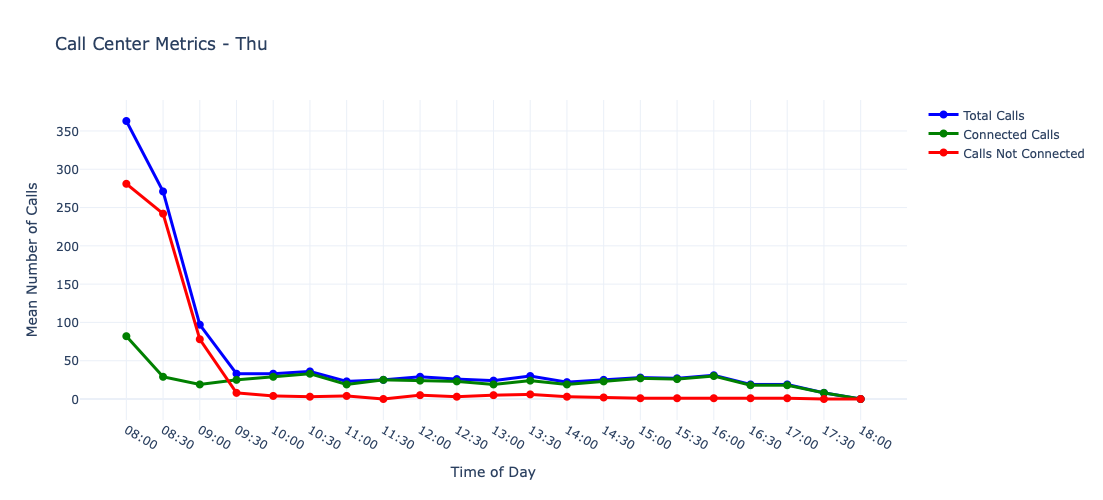


�� Summary for Thu:
Total Calls - Mean: 55.7, Max: 363.0
Connected Calls - Mean: 24.8, Max: 82.0
Calls Not Connected - Mean: 30.9, Max: 281.0
--------------------------------------------------


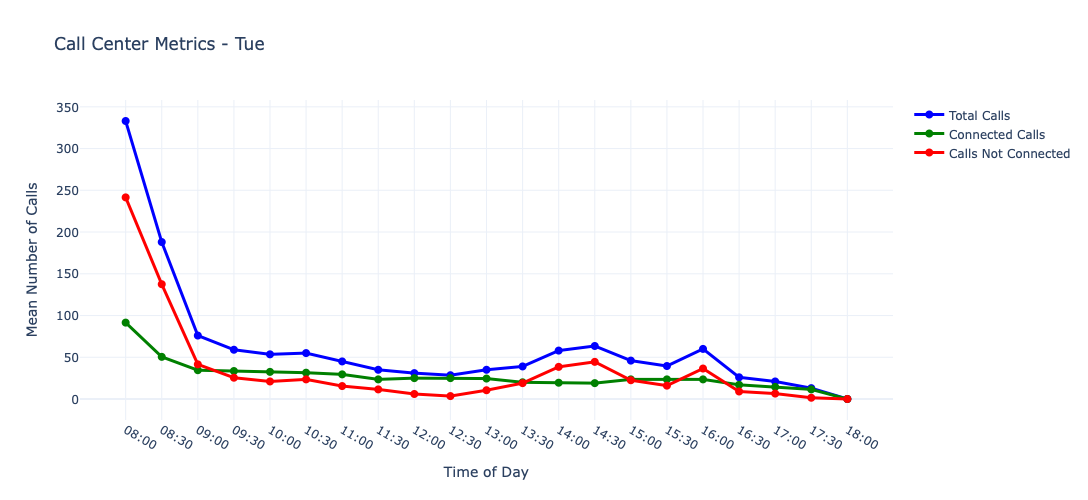


�� Summary for Tue:
Total Calls - Mean: 62.1, Max: 333.0
Connected Calls - Mean: 27.3, Max: 91.5
Calls Not Connected - Mean: 34.8, Max: 241.5
--------------------------------------------------


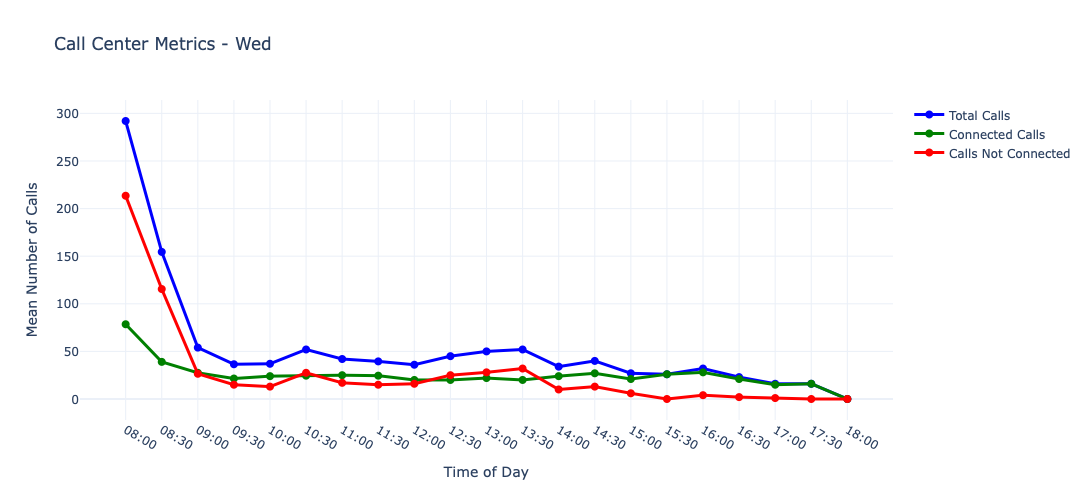


�� Summary for Wed:
Total Calls - Mean: 52.6, Max: 292.0
Connected Calls - Mean: 25.0, Max: 78.5
Calls Not Connected - Mean: 27.6, Max: 213.5
--------------------------------------------------


In [5]:
# Analyze Total Calls, Connected Calls, and Calls Not Connected by day and time

# Group by Day and Time, calculate means for the three key columns
daily_means = df.groupby(['Day', 'Time'])[['Total Calls', 'Connected Calls', 'Calls Not Connected']].mean().reset_index()

# Create interactive plots for each weekday
days = sorted(df['Day'].unique())

for day in days:
    # Filter data for this day
    day_data = daily_means[daily_means['Day'] == day]
    
    # Create the plot
    fig = go.Figure()
    
    # Add lines for each metric
    fig.add_trace(go.Scatter(
        x=day_data['Time'], 
        y=day_data['Total Calls'],
        mode='lines+markers',
        name='Total Calls',
        line=dict(color='blue', width=3),
        marker=dict(size=8)
    ))
    
    fig.add_trace(go.Scatter(
        x=day_data['Time'], 
        y=day_data['Connected Calls'],
        mode='lines+markers',
        name='Connected Calls',
        line=dict(color='green', width=3),
        marker=dict(size=8)
    ))
    
    fig.add_trace(go.Scatter(
        x=day_data['Time'], 
        y=day_data['Calls Not Connected'],
        mode='lines+markers',
        name='Calls Not Connected',
        line=dict(color='red', width=3),
        marker=dict(size=8)
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Call Center Metrics - {day}',
        xaxis_title='Time of Day',
        yaxis_title='Mean Number of Calls',
        hovermode='x unified',
        template='plotly_white',
        height=500
    )
    
    # Show the plot
    fig.show()
    
    # Print summary statistics for this day
    print(f"\n�� Summary for {day}:")
    print(f"Total Calls - Mean: {day_data['Total Calls'].mean():.1f}, Max: {day_data['Total Calls'].max():.1f}")
    print(f"Connected Calls - Mean: {day_data['Connected Calls'].mean():.1f}, Max: {day_data['Connected Calls'].max():.1f}")
    print(f"Calls Not Connected - Mean: {day_data['Calls Not Connected'].mean():.1f}, Max: {day_data['Calls Not Connected'].max():.1f}")
    print("-" * 50)